## This notebook contains the data acquisition pipeline for our project

### Section 0 : imports and function definitions

In [13]:
import pandas as pd
import numpy as np
import re
import wikipedia
import datetime
import requests
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import json
import urllib
from urllib.parse import urlencode
from urllib.request import urlopen
from collections import deque
# documentation: https://mwparserfromhell.readthedocs.io/en/latest/api/mwparserfromhell.nodes.html#module-mwparserfromhell.nodes.wikilink
import mwparserfromhell
import networkx as nx
import random
from helpers import page_visits
import pickle



In [4]:
%matplotlib inline

In [12]:
## data folders
data_folder = '../data/'
plots_folder = '../plots/'

In [6]:
API_URL = "https://en.wikipedia.org/w/api.php"
def parse_with_date(title, date=None):
    '''
    Function to retrieve the wikipedia article with name <title> as it was on date <date>
    :param title: title of the wikipedia article
    :param date: snapshot of the page as it was on the date. If None, scrapes the page as is now. 
    :return: the parsed page of wikipedia
    '''
    data = {"action": "query", "prop": "revisions", "rvlimit": 1,
            "rvprop": "content", "format": "json", "titles": title}
    if date is not None:
        data["rvstart"] = date
    raw = urlopen(API_URL, urlencode(data).encode()).read()
    res = json.loads(raw)
    try:
        text = list(res["query"]["pages"].values())[0]["revisions"][0]["*"]
    except KeyError as err:
        print("Key error".format(err))
        print(title)
        return None
    return mwparserfromhell.parse(text)

A heuristic we use for sampling is to give more probability to the links at the front of the page (assuming they might be more important and more related to the subject) than to the other links.

In [7]:
def sample_links(n_links, n_links_sample, percentage_l, percentage_l_subsample):
    '''
    Function to subsample links from an ordered list of links
    :param n_links: number of links a page has
    :param n_links_sample: number of links you want to sample
    :param percentage_l: consider the top percentage_l links ..
    :param percentage_l_subsample: to account for percentage_l_subsample of the subsampled links
    :return:  the chosen indices of the sampled links 
    Example call: from a list of <n_links> links, subsample <n_links_sample> links, such that the top <percentage_l>
    of the links account for <percentage_l_subsample> of the sample.
    '''
    # no sampling needed here
    if n_links_sample >= n_links:
        return np.array(range(n_links))
    
    # how many links from the first group should be subsampled
    n_links_first_group = int(n_links_sample * percentage_l_subsample)
    # how many links from the first group we have
    n_links_first_group_pop = int(n_links * percentage_l)
    
    # no sampling from the first group
    if n_links_first_group_pop < n_links_first_group:
        links_chosen_group_1 = np.array(range(n_links_first_group_pop))
        remaining = n_links_sample - n_links_first_group_pop
        links_chosen_group_2 = np.random.choice(range(n_links_first_group_pop+1, n_links), size = remaining, replace= False)
        return np.append(links_chosen_group_1, links_chosen_group_2)
    
    # if we have to sample from both groups, create the probabilities 
    perc_1 = percentage_l_subsample / n_links_first_group_pop
    perc_2 = (1 - percentage_l_subsample) / (n_links - n_links_first_group_pop)
    #print('Links from first group were sampled with p ', perc_1, ' and links from second group were sampled with p ', perc_2)
    p = [perc_1] * n_links_first_group_pop + [perc_2] * (n_links - n_links_first_group_pop)
    chosen_links = np.random.choice(n_links, size = n_links_sample, p = p, replace=False)
    return chosen_links

In [8]:
def preprocess_links(links):
    '''
    Function to convert links from wikiCode objects to string type and to filter out the non-relevant links
    '''
    non_link = re.compile('Category:|File:|wikt:|.*#.*')
    links = [str(link.title) for link in links if non_link.match(str(link.title))==None]
    links = list(set(links))
    return links

For crawling, we use the below function

In [21]:
def wiki_crawl(seed, date, max_nodes = 2701, n_links_hop1 = 150, n_links_indirect = 3, min_popularity = 30 ):
    '''
    
    :param seed: page from which crawl begins
    :param date: date at which pages are crawled
    :param max_nodes: maximum number of nodes of the resulting graph
    :param n_links_hop1: how many direct neighbours
    :param n_links_indirect: how many indirect neighbours
    :param min_popularity: the minimum number of links a page should have to be taken into the graph (to avoid stubs or really small articles)
    :return: 
    '''
    # init algo
    article_links = {}
    queue = deque([seed])

    while(len(article_links) < max_nodes):
        if len(queue) == 0:
            print('no more links to dequeue')
            break
        article = queue.popleft()
        # crawl it
        article_content = parse_with_date(title=article, date=date)
        # check parse succesful
        if article_content is not None:
            links = article_content.filter_wikilinks()
            links = preprocess_links(links)
            # filter out the links that are 1st hop neighbors
            if seed in article_links.keys():
                links = [link for link in links if link not in article_links[seed]]
            #print(len(links))
            if (len(links) > min_popularity):
                article_links[article] = links
                if article == seed:
                    print('Added direct', article, ' to the graph')
                    idx_chosen_links = sample_links(n_links=len(links), n_links_sample=n_links_hop1, percentage_l=0.1, percentage_l_subsample=0.5)
                else:
                    print('Added INdirect', article, ' to the graph')
                    idx_chosen_links = sample_links(n_links=len(links), n_links_sample=n_links_indirect, percentage_l=0.2, percentage_l_subsample=0.5 )
                for idx in idx_chosen_links:
                    if links[idx] not in article_links and links[idx] not in queue:
                        queue.append(links[idx])
        if(len(article_links) % 100):
            print('Crawled ',len(article_links), 'articles' )
    return article_links

In [10]:
def construct_graph(links):
    '''
    
    :param links: a dictionary mapping crawled articles to their links as listed on wiki page  
    :return: graph
    '''
    G = nx.DiGraph()
    G.add_nodes_from(links.keys())
    for article in G.nodes():
        for link in links[article]:
            # add link if not self-loop
            if link in links and link != article:
                G.add_edge(article, link)
    return G

In [14]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [44]:
def get_page_signal(G, start, end):
    '''
    
    :param G: graph for which we are getting the signal
    :param start: start time for getting the views (date time object)
    :param end: end time for getting the views (date time object)
    :return: a dictionary mapping nodes to views and a list of nodes for which the signal could not be obtained
    '''
    views = {}
    nodes_not_taken = []
    for node in G.nodes():
        try:
            views[node] = page_visits.getUserActivity(article=node, granularity="daily",start=start,end=end,dateformat="iso")
        except KeyError:
            nodes_not_taken.append(node)
    return views, nodes_not_taken

### Section 1: Views over time for the central articles

In [15]:
articles_w_date = [
        ('Stan Lee', '2018-11-12'),
        ('Stephen Hawking', '2018-03-14'),
        ('Alan Rickman', '2016-01-14')
    ]

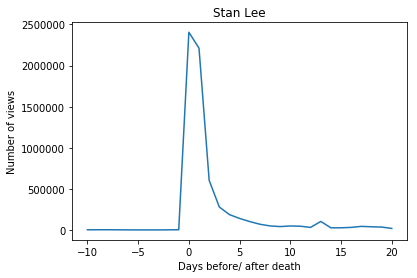

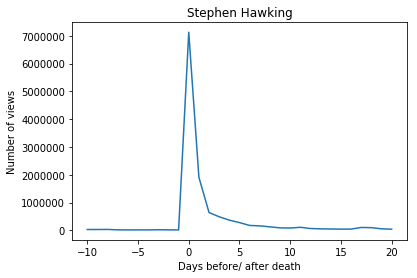

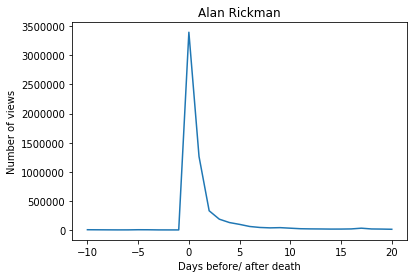

In [17]:
ndaysbefore = 10
ndaysafter = 20

for article, datestr in articles_w_date:
    date = datetime.datetime.strptime(datestr, '%Y-%m-%d')
    start = date - datetime.timedelta(days=ndaysbefore)
    end = date + datetime.timedelta(days=ndaysafter)

    outname = ''.join(c for c in article if c.isalnum())

    views = page_visits.getUserActivity(article=article,
                            granularity="daily",
                            start=start,
                            end=end,
                            dateformat="iso")
    views_file = data_folder + '1_' + outname + '_views.pkl'
    plot_file = plots_folder + '1_' + outname + '.png'
    save_object(views, views_file)

    y = [x[0] for x in views]
    x = np.arange(-ndaysbefore, ndaysafter+1)
    plt.plot(x, y)
    plt.xlabel('Days before/ after death')
    plt.ylabel('Number of views')
    plt.title(article)
    plt.savefig(plot_file)
    plt.show()


### Section 2: obtaining graphs

In [32]:
seed = 'Stan Lee'
date = '2018-11-13T00:00:00Z'
links_stan_lee = wiki_crawl(seed, date=date )

Added direct Stan Lee  to the graph
Crawled  1 articles
Added INdirect Marvel Cinematic Universe  to the graph
Crawled  2 articles
Added INdirect BBC Four  to the graph
Crawled  3 articles
Added INdirect Slate  to the graph
Crawled  4 articles
Added INdirect Fantastic Four  to the graph
Crawled  5 articles
Added INdirect Silver Surfer  to the graph
Crawled  6 articles
Crawled  6 articles
Added INdirect Les Daniels  to the graph
Crawled  7 articles
Crawled  7 articles
Added INdirect List of American comics creators  to the graph
Crawled  8 articles
Added INdirect Spider-Man  to the graph
Crawled  9 articles
Added INdirect List of pseudonyms  to the graph
Crawled  10 articles
Added INdirect Fantastic Four (comic book)  to the graph
Crawled  11 articles
Added INdirect Tales to Astonish  to the graph
Crawled  12 articles
Crawled  12 articles
Added INdirect University of Wyoming  to the graph
Crawled  13 articles
Crawled  13 articles
Added INdirect Don Heck  to the graph
Crawled  14 article

Crawled  110 articles
Added INdirect Star-Lord  to the graph
Crawled  111 articles
Added INdirect Jeph Loeb  to the graph
Crawled  112 articles
Added INdirect Ben Kingsley  to the graph
Crawled  113 articles
Added INdirect Ever Decreasing Circles  to the graph
Crawled  114 articles
Added INdirect I, Claudius (TV series)  to the graph
Crawled  115 articles
Added INdirect CBBC (TV channel)  to the graph
Crawled  116 articles
Crawled  116 articles
Added INdirect Belgium  to the graph
Crawled  117 articles
Crawled  117 articles
Crawled  117 articles
Added INdirect mass media  to the graph
Crawled  118 articles
Added INdirect Leonard Kirk  to the graph
Crawled  119 articles
Added INdirect exile  to the graph
Crawled  120 articles
Added INdirect Firestar (Marvel Comics)  to the graph
Crawled  121 articles
Crawled  121 articles
Added INdirect misanthropy  to the graph
Crawled  122 articles
Added INdirect Charles Scribner's Sons  to the graph
Crawled  123 articles
Added INdirect Little, Brown 

Added INdirect Action Comics 1000  to the graph
Crawled  212 articles
Added INdirect Alex Raymond  to the graph
Crawled  213 articles
Added INdirect Initial public offering  to the graph
Crawled  214 articles
Added INdirect List of Pulitzer Prizes awarded to The New York Times  to the graph
Crawled  215 articles
Crawled  215 articles
Crawled  215 articles
Added INdirect Gus Meins  to the graph
Crawled  216 articles
Crawled  216 articles
Crawled  216 articles
Added INdirect Black Widow (Natasha Romanova)  to the graph
Crawled  217 articles
Added INdirect Luke Cage (TV series)  to the graph
Crawled  218 articles
Crawled  218 articles
Crawled  218 articles
Crawled  218 articles
Crawled  218 articles
Added INdirect Ghost character  to the graph
Crawled  219 articles
Crawled  219 articles
Added INdirect Thanos  to the graph
Crawled  220 articles
Key error
Dan Chariton
Crawled  220 articles
Added INdirect Rocky the Flying Squirrel  to the graph
Crawled  221 articles
Added INdirect Anthropomo

Added INdirect Tate  to the graph
Crawled  313 articles
Added INdirect garden design  to the graph
Crawled  314 articles
Added INdirect The Simpsons  to the graph
Crawled  315 articles
Added INdirect cloning  to the graph
Crawled  316 articles
Added INdirect Typecasting (acting)  to the graph
Crawled  317 articles
Added INdirect Scooby-Doo  to the graph
Crawled  318 articles
Added INdirect Raymond Chandler  to the graph
Crawled  319 articles
Added INdirect O. Henry  to the graph
Crawled  320 articles
Added INdirect Solomon Kane  to the graph
Crawled  321 articles
Added INdirect Al Milgrom  to the graph
Crawled  322 articles
Added INdirect Guardians of the Galaxy Vol. 2  to the graph
Crawled  323 articles
Added INdirect Marvel Preview  to the graph
Crawled  324 articles
Crawled  324 articles
Added INdirect The Dreaming (comics)  to the graph
Crawled  325 articles
Added INdirect Batman (comic book)  to the graph
Crawled  326 articles
Added INdirect Royal Shakespeare Company  to the graph

Crawled  422 articles
Added INdirect Black Canary  to the graph
Crawled  423 articles
Added INdirect Legion of Super-Heroes  to the graph
Crawled  424 articles
Added INdirect Saturn Girl  to the graph
Crawled  425 articles
Added INdirect Internet  to the graph
Crawled  426 articles
Added INdirect planking (fad)  to the graph
Crawled  427 articles
Added INdirect News agency  to the graph
Crawled  428 articles
Added INdirect Berlin  to the graph
Crawled  429 articles
Added INdirect Arabic  to the graph
Crawled  430 articles
Added INdirect Nassau County, New York  to the graph
Crawled  431 articles
Added INdirect Ann Arbor, Michigan  to the graph
Crawled  432 articles
Added INdirect Michigan  to the graph
Crawled  433 articles
Added INdirect War (band)  to the graph
Crawled  434 articles
Crawled  434 articles
Crawled  434 articles
Key error
The Story Of The Jews
Crawled  434 articles
Added INdirect International Brotherhood of Electrical Workers  to the graph
Crawled  435 articles
Added I

Added INdirect 20th Century Fox  to the graph
Crawled  527 articles
Added INdirect Fox8  to the graph
Crawled  528 articles
Added INdirect Fawcett Publications  to the graph
Crawled  529 articles
Added INdirect Toby Emmerich  to the graph
Crawled  530 articles
Added INdirect Fred MacMurray  to the graph
Crawled  531 articles
Added INdirect Louise Simonson  to the graph
Crawled  532 articles
Added INdirect Jerry Siegel  to the graph
Crawled  533 articles
Added INdirect Lex Luthor  to the graph
Crawled  534 articles
Added INdirect Dale Arden  to the graph
Crawled  535 articles
Added INdirect Jim Aparo  to the graph
Crawled  536 articles
Added INdirect Gasoline Alley  to the graph
Crawled  537 articles
Crawled  537 articles
Crawled  537 articles
Crawled  537 articles
Crawled  537 articles
Added INdirect 1976 Pulitzer Prize  to the graph
Crawled  538 articles
Added INdirect 1979 Pulitzer Prize  to the graph
Crawled  539 articles
Crawled  539 articles
Added INdirect 1935 in film  to the gra

Added INdirect India  to the graph
Crawled  627 articles
Crawled  627 articles
Added INdirect Primetime Emmy Award  to the graph
Crawled  628 articles
Added INdirect High-definition television  to the graph
Crawled  629 articles
Crawled  629 articles
Crawled  629 articles
Crawled  629 articles
Key error
TV Tokyo Medianet
Crawled  629 articles
Crawled  629 articles
Crawled  629 articles
Added INdirect Lizard  to the graph
Crawled  630 articles
Added INdirect Agatha Christie's Great Detectives Poirot and Marple  to the graph
Crawled  631 articles
Added INdirect Power Stone 2  to the graph
Crawled  632 articles
Added INdirect Piero della Francesca  to the graph
Crawled  633 articles
Crawled  633 articles
Crawled  633 articles
Crawled  633 articles
Added INdirect River Mersey  to the graph
Crawled  634 articles
Crawled  634 articles
Crawled  634 articles
Crawled  634 articles
Added INdirect Gold (2016 film)  to the graph
Crawled  635 articles
Added INdirect Scorpion (TV series)  to the gra

Crawled  731 articles
Crawled  731 articles
Crawled  731 articles
Added INdirect Underworld (film series)  to the graph
Crawled  732 articles
Added INdirect Patrick Tatopoulos  to the graph
Crawled  733 articles
Added INdirect Elizabeth I of England  to the graph
Crawled  734 articles
Added INdirect Guardians of the Galaxy (1969 team)  to the graph
Crawled  735 articles
Added INdirect Unknown Soldier (DC Comics)  to the graph
Crawled  736 articles
Added INdirect io9  to the graph
Crawled  737 articles
Crawled  737 articles
Added INdirect Entertainment Tonight  to the graph
Crawled  738 articles
Added INdirect Hercules (Marvel Comics)  to the graph
Crawled  739 articles
Added INdirect Lilith (Marvel Comics)  to the graph
Crawled  740 articles
Added INdirect Nightcrawler (comics)  to the graph
Crawled  741 articles
Added INdirect The Sandman (Vertigo)  to the graph
Crawled  742 articles
Added INdirect 2000 AD (comics)  to the graph
Crawled  743 articles
Crawled  743 articles
Added INdire

Added INdirect Wally Wood  to the graph
Crawled  840 articles
Added INdirect Everyman  to the graph
Crawled  841 articles
Added INdirect Union Army  to the graph
Crawled  842 articles
Added INdirect List of African-American United States Senators  to the graph
Crawled  843 articles
Added INdirect political party  to the graph
Crawled  844 articles
Crawled  844 articles
Added INdirect Henry Kissinger  to the graph
Crawled  845 articles
Added INdirect Storm chasing  to the graph
Crawled  846 articles
Added INdirect Alpha Phi Omega  to the graph
Crawled  847 articles
Added INdirect United States Department of Justice  to the graph
Crawled  848 articles
Added INdirect Bureau of Industry and Security  to the graph
Crawled  849 articles
Crawled  849 articles
Added INdirect angel  to the graph
Crawled  850 articles
Added INdirect Gatlinburg, Tennessee  to the graph
Crawled  851 articles
Added INdirect National Panhellenic Conference  to the graph
Crawled  852 articles
Added INdirect Katie Cou

Added INdirect Scooby-Doo! WrestleMania Mystery  to the graph
Crawled  946 articles
Added INdirect Justice League: Doom  to the graph
Crawled  947 articles
Added INdirect Dick Giordano  to the graph
Crawled  948 articles
Added INdirect League of Assassins  to the graph
Crawled  949 articles
Added INdirect Chuck Dixon  to the graph
Crawled  950 articles
Added INdirect Pat Broderick  to the graph
Crawled  951 articles
Added INdirect Blackthorne Publishing  to the graph
Crawled  952 articles
Added INdirect Mark Waid  to the graph
Crawled  953 articles
Added INdirect Arrowverse  to the graph
Crawled  954 articles
Added INdirect catatonia  to the graph
Crawled  955 articles
Key error
Titan (DC Comics)
Crawled  955 articles
Crawled  955 articles
Added INdirect intranet  to the graph
Crawled  956 articles
Crawled  956 articles
Added INdirect CNN  to the graph
Crawled  957 articles
Key error
Don%27t_Leave_Me_(Ne_Me_Quitte_Pas)
Crawled  957 articles
Crawled  957 articles
Crawled  957 articles
C

Crawled  1042 articles
Crawled  1042 articles
Added INdirect Trina Robbins  to the graph
Crawled  1043 articles
Added INdirect zine  to the graph
Crawled  1044 articles
Crawled  1044 articles
Crawled  1044 articles
Added INdirect Misanthropy  to the graph
Crawled  1045 articles
Added INdirect VHS  to the graph
Crawled  1046 articles
Added INdirect Aspect ratio (image)  to the graph
Crawled  1047 articles
Added INdirect Lady Styx  to the graph
Crawled  1048 articles
Added INdirect Phil LaMarr  to the graph
Crawled  1049 articles
Added INdirect JLA: Earth 2  to the graph
Crawled  1050 articles
Added INdirect Bruce Thomas (actor)  to the graph
Crawled  1051 articles
Added INdirect Faces of Evil  to the graph
Crawled  1052 articles
Added INdirect Convergence (comics)  to the graph
Crawled  1053 articles
Added INdirect Batman: The Brave and the Bold  to the graph
Crawled  1054 articles
Added INdirect Pig Goat Banana Cricket  to the graph
Crawled  1055 articles
Added INdirect Kingdom Hearts 

Added INdirect WWE Superstars  to the graph
Crawled  1147 articles
Added INdirect Maximum Exposure  to the graph
Crawled  1148 articles
Added INdirect Television in Australia  to the graph
Crawled  1149 articles
Added INdirect World War II  to the graph
Crawled  1150 articles
Crawled  1150 articles
Added INdirect Spanish–American War  to the graph
Crawled  1151 articles
Added INdirect The Wedding Singer  to the graph
Crawled  1152 articles
Crawled  1152 articles
Added INdirect Snakes on a Plane  to the graph
Crawled  1153 articles
Added INdirect Billy Wilder  to the graph
Crawled  1154 articles
Crawled  1154 articles
Crawled  1154 articles
Added INdirect Shaquille O'Neal  to the graph
Crawled  1155 articles
Added INdirect Action Comics  to the graph
Crawled  1156 articles
Crawled  1156 articles
Crawled  1156 articles
Added INdirect Plaza Hotel  to the graph
Crawled  1157 articles
Crawled  1157 articles
Added INdirect Fred Tatasciore  to the graph
Crawled  1158 articles
Added INdirect c

Crawled  1254 articles
Added INdirect Julie Power  to the graph
Crawled  1255 articles
Crawled  1255 articles
Added INdirect Bob Hall (comics)  to the graph
Crawled  1256 articles
Added INdirect Jim McCann (writer)  to the graph
Crawled  1257 articles
Crawled  1257 articles
Added INdirect Solar wind  to the graph
Crawled  1258 articles
Added INdirect International Cosmic Ray Conference  to the graph
Crawled  1259 articles
Crawled  1259 articles
Crawled  1259 articles
Added INdirect Warner Bros. Animation  to the graph
Crawled  1260 articles
Added INdirect Fraggle Rock  to the graph
Crawled  1261 articles
Added INdirect Bigfoot and the Muscle Machines  to the graph
Crawled  1262 articles
Added INdirect publishing  to the graph
Crawled  1263 articles
Crawled  1263 articles
Crawled  1263 articles
Crawled  1263 articles
Added INdirect Martín Miguel de Güemes  to the graph
Crawled  1264 articles
Added INdirect José de San Martín  to the graph
Crawled  1265 articles
Added INdirect Bernardino

Key error
Museo Civico Sansepolcro
Crawled  1357 articles
Added INdirect Siena  to the graph
Crawled  1358 articles
Crawled  1358 articles
Added INdirect British Geological Survey  to the graph
Crawled  1359 articles
Added INdirect Runcorn  to the graph
Crawled  1360 articles
Added INdirect Daniel Pemberton  to the graph
Crawled  1361 articles
Added INdirect Michael Landes  to the graph
Crawled  1362 articles
Added INdirect 43rd Saturn Awards  to the graph
Crawled  1363 articles
Added INdirect RTÉ2  to the graph
Crawled  1364 articles
Crawled  1364 articles
Added INdirect CBS Television Studios  to the graph
Crawled  1365 articles
Crawled  1365 articles
Added INdirect Connie Nielsen  to the graph
Crawled  1366 articles
Added INdirect Saturn Award for Best Actor on Television  to the graph
Crawled  1367 articles
Added INdirect Empire (season 3)  to the graph
Crawled  1368 articles
Added INdirect NAACP Image Award for Outstanding Duo or Group  to the graph
Crawled  1369 articles
Added IN

Added INdirect Blue Beetle  to the graph
Crawled  1457 articles
Added INdirect Wallace Langham  to the graph
Crawled  1458 articles
Crawled  1458 articles
Added INdirect Entertainment Weekly  to the graph
Crawled  1459 articles
Added INdirect Woodrow Wilson  to the graph
Crawled  1460 articles
Added INdirect Alice Boughton  to the graph
Crawled  1461 articles
Added INdirect Boston University  to the graph
Crawled  1462 articles
Added INdirect Duel in the Sun (film)  to the graph
Crawled  1463 articles
Added INdirect Citizen Kane  to the graph
Crawled  1464 articles
Crawled  1464 articles
Crawled  1464 articles
Added INdirect Gangster Squad (film)  to the graph
Crawled  1465 articles
Added INdirect Bryan Cranston  to the graph
Crawled  1466 articles
Added INdirect Sabrina (1954 film)  to the graph
Crawled  1467 articles
Added INdirect Reach for the Sky  to the graph
Crawled  1468 articles
Added INdirect Uma Thurman  to the graph
Crawled  1469 articles
Crawled  1469 articles
Crawled  146

Added INdirect Amadeus Cho  to the graph
Crawled  1560 articles
Added INdirect Cable (comics)  to the graph
Crawled  1561 articles
Added INdirect Matthew Mercer  to the graph
Crawled  1562 articles
Added INdirect Steel Vengeance  to the graph
Crawled  1563 articles
Added INdirect American comic book  to the graph
Crawled  1564 articles
Crawled  1564 articles
Added INdirect Nolan North  to the graph
Crawled  1565 articles
Key error
Crimson Pirates
Crawled  1565 articles
Added INdirect Pocket Books  to the graph
Crawled  1566 articles
Added INdirect Dave McKean  to the graph
Crawled  1567 articles
Added INdirect Geoff Johns  to the graph
Crawled  1568 articles
Crawled  1568 articles
Crawled  1568 articles
Added INdirect Chris Weston  to the graph
Crawled  1569 articles
Crawled  1569 articles
Added INdirect Haly's Circus  to the graph
Crawled  1570 articles
Added INdirect Firestorm (comics)  to the graph
Crawled  1571 articles
Added INdirect Major Disaster  to the graph
Crawled  1572 arti

Crawled  1664 articles
Crawled  1664 articles
Crawled  1664 articles
Crawled  1664 articles
Added INdirect Howard H. Aiken  to the graph
Crawled  1665 articles
Key error
q:Computer science
Crawled  1665 articles
Added INdirect Kurt Gödel  to the graph
Crawled  1666 articles
Added INdirect soul  to the graph
Crawled  1667 articles
Added INdirect personality  to the graph
Crawled  1668 articles
Added INdirect Ekam  to the graph
Crawled  1669 articles
Added INdirect Ludwig Wittgenstein  to the graph
Crawled  1670 articles
Added INdirect John Maynard Keynes  to the graph
Crawled  1671 articles
Added INdirect Russell–Einstein Manifesto  to the graph
Crawled  1672 articles
Added INdirect broadcast delay  to the graph
Crawled  1673 articles
Added INdirect late night television  to the graph
Crawled  1674 articles
Added INdirect Trey Gowdy  to the graph
Crawled  1675 articles
Crawled  1675 articles
Added INdirect What Price Innocence?  to the graph
Crawled  1676 articles
Added INdirect Outline

Crawled  1766 articles
Crawled  1766 articles
Added INdirect Independent agencies of the United States government  to the graph
Crawled  1767 articles
Added INdirect Fairy  to the graph
Crawled  1768 articles
Added INdirect loros  to the graph
Crawled  1769 articles
Added INdirect Gabriel  to the graph
Crawled  1770 articles
Crawled  1770 articles
Crawled  1770 articles
Crawled  1770 articles
Added INdirect Jews  to the graph
Crawled  1771 articles
Added INdirect Sigma Sigma Sigma  to the graph
Crawled  1772 articles
Crawled  1772 articles
Added INdirect Hugh Jackman  to the graph
Crawled  1773 articles
Crawled  1773 articles
Added INdirect University of Maryland University College  to the graph
Crawled  1774 articles
Added INdirect Higher Learning Commission  to the graph
Crawled  1775 articles
Crawled  1775 articles
Key error
United States House of Representatives elections, 2006
Crawled  1775 articles
Added INdirect at-large  to the graph
Crawled  1776 articles
Key error
United Stat

Added INdirect Rotten Tomatoes  to the graph
Crawled  1864 articles
Added INdirect Humphrey Bogart  to the graph
Crawled  1865 articles
Added INdirect Jerry Wald  to the graph
Crawled  1866 articles
Crawled  1866 articles
Added INdirect List of capitals in the United States  to the graph
Crawled  1867 articles
Added INdirect Savannah, Georgia  to the graph
Crawled  1868 articles
Added INdirect Groucho Marx  to the graph
Crawled  1869 articles
Crawled  1869 articles
Crawled  1869 articles
Crawled  1869 articles
Crawled  1869 articles
Added INdirect restaurant  to the graph
Crawled  1870 articles
Added INdirect Philadelphia  to the graph
Crawled  1871 articles
Added INdirect Spelman College  to the graph
Crawled  1872 articles
Crawled  1872 articles
Added INdirect feminist economics  to the graph
Crawled  1873 articles
Added INdirect International Monetary Fund  to the graph
Crawled  1874 articles
Added INdirect Moscow  to the graph
Crawled  1875 articles
Added INdirect Mily Balakirev  t

Added INdirect Zanzibar red colobus  to the graph
Crawled  1967 articles
Added INdirect Bantu peoples  to the graph
Crawled  1968 articles
Crawled  1968 articles
Added INdirect semiring  to the graph
Crawled  1969 articles
Added INdirect full stop  to the graph
Crawled  1970 articles
Crawled  1970 articles
Crawled  1970 articles
Crawled  1970 articles
Added INdirect List of sovereign states  to the graph
Crawled  1971 articles
Crawled  1971 articles
Crawled  1971 articles
Added INdirect Steve Madden  to the graph
Crawled  1972 articles
Crawled  1972 articles
Added INdirect Hewlett, New York  to the graph
Crawled  1973 articles
Crawled  1973 articles
Added INdirect Youth empowerment  to the graph
Crawled  1974 articles
Key error
Parkway High School (Philadelphia)
Crawled  1974 articles
Added INdirect denial-of-service attack  to the graph
Crawled  1975 articles
Crawled  1975 articles
Added INdirect Internet service provider  to the graph
Crawled  1976 articles
Crawled  1976 articles
Add

Added INdirect The Brave and the Bold  to the graph
Crawled  2064 articles
Added INdirect Bruce Lee (comics)  to the graph
Crawled  2065 articles
Added INdirect Orion (comics)  to the graph
Crawled  2066 articles
Crawled  2066 articles
Added INdirect Hollywood  to the graph
Crawled  2067 articles
Crawled  2067 articles
Added INdirect Kurt Weill  to the graph
Crawled  2068 articles
Added INdirect Giulio Cesare  to the graph
Crawled  2069 articles
Added INdirect Gioachino Rossini  to the graph
Crawled  2070 articles
Added INdirect Pope Julius III  to the graph
Crawled  2071 articles
Added INdirect Burton P. C. Hall  to the graph
Crawled  2072 articles
Added INdirect Vatican City  to the graph
Crawled  2073 articles
Added INdirect Sherlock Holmes  to the graph
Crawled  2074 articles
Crawled  2074 articles
Added INdirect Santa Monica, California  to the graph
Crawled  2075 articles
Added INdirect Ra's al Ghul  to the graph
Crawled  2076 articles
Added INdirect Garry Trudeau  to the graph
C

Added INdirect apse  to the graph
Crawled  2167 articles
Added INdirect Pompeii  to the graph
Crawled  2168 articles
Added INdirect Athanasian Creed  to the graph
Crawled  2169 articles
Added INdirect Darius the Mede  to the graph
Crawled  2170 articles
Crawled  2170 articles
Added INdirect militia  to the graph
Crawled  2171 articles
Added INdirect Vermont Republic  to the graph
Crawled  2172 articles
Crawled  2172 articles
Added INdirect Blazon  to the graph
Crawled  2173 articles
Crawled  2173 articles
Added INdirect Edmund Herring  to the graph
Crawled  2174 articles
Added INdirect Frank Forde  to the graph
Crawled  2175 articles
Added INdirect President of the Philippines  to the graph
Crawled  2176 articles
Added INdirect Sun-Times Media Group  to the graph
Crawled  2177 articles
Added INdirect Austin, Texas  to the graph
Crawled  2178 articles
Added INdirect Christopher Drake  to the graph
Crawled  2179 articles
Added INdirect Kevin Conroy  to the graph
Crawled  2180 articles
Cr

Added INdirect Shirley MacLaine  to the graph
Crawled  2273 articles
Added INdirect Croatia  to the graph
Crawled  2274 articles
Added INdirect Humanism  to the graph
Crawled  2275 articles
Added INdirect ciao  to the graph
Crawled  2276 articles
Added INdirect Azrael (comics)  to the graph
Crawled  2277 articles
Crawled  2277 articles
Added INdirect Fisher King  to the graph
Crawled  2278 articles
Added INdirect Kryptonian  to the graph
Crawled  2279 articles
Crawled  2279 articles
Added INdirect PlayStation Store  to the graph
Crawled  2280 articles
Key error
The Tender Box
Crawled  2280 articles
Added INdirect Kraven the Hunter  to the graph
Crawled  2281 articles
Added INdirect Pete Morisi  to the graph
Crawled  2282 articles
Crawled  2282 articles
Crawled  2282 articles
Added INdirect Battlestar Galactica: The Face of the Enemy  to the graph
Crawled  2283 articles
Added INdirect Galactica 1980  to the graph
Crawled  2284 articles
Crawled  2284 articles
Added INdirect Joe Orlando  

Crawled  2372 articles
Crawled  2372 articles
Added INdirect Carver Mead  to the graph
Crawled  2373 articles
Added INdirect University of California, Riverside  to the graph
Crawled  2374 articles
Added INdirect George R. R. Martin  to the graph
Crawled  2375 articles
Added INdirect obsidian  to the graph
Crawled  2376 articles
Crawled  2376 articles
Added INdirect standard deviation  to the graph
Crawled  2377 articles
Crawled  2377 articles
Added INdirect pre-eclampsia  to the graph
Crawled  2378 articles
Crawled  2378 articles
Added INdirect MP3 player  to the graph
Crawled  2379 articles
Key error
Fast Company (magazine)
Crawled  2379 articles
Added INdirect Noah Baumbach  to the graph
Crawled  2380 articles
Added INdirect Whiplash (2014 film)  to the graph
Crawled  2381 articles
Added INdirect Mooncake  to the graph
Crawled  2382 articles
Added INdirect Western culture  to the graph
Crawled  2383 articles
Added INdirect Ryukyuan religion  to the graph
Crawled  2384 articles
Added

Added INdirect speciesism  to the graph
Crawled  2470 articles
Added INdirect happiness  to the graph
Crawled  2471 articles
Crawled  2471 articles
Crawled  2471 articles
Added INdirect Susquehannock  to the graph
Crawled  2472 articles
Added INdirect Mississippi River  to the graph
Crawled  2473 articles
Added INdirect Super Buddies  to the graph
Crawled  2474 articles
Added INdirect Dean Cain  to the graph
Crawled  2475 articles
Added INdirect Shaun Toub  to the graph
Crawled  2476 articles
Added INdirect Lois & Clark: The New Adventures of Superman (season 3)  to the graph
Crawled  2477 articles
Added INdirect Adventure Comics  to the graph
Crawled  2478 articles
Crawled  2478 articles
Added INdirect Big Barda  to the graph
Crawled  2479 articles
Added INdirect Commander Steel  to the graph
Crawled  2480 articles
Added INdirect Joe Bennett (artist)  to the graph
Crawled  2481 articles
Added INdirect Air Medal  to the graph
Crawled  2482 articles
Crawled  2482 articles
Crawled  2482 

Added INdirect Fear Itself (comics)  to the graph
Crawled  2574 articles
Added INdirect Attuma  to the graph
Crawled  2575 articles
Added INdirect E. C. Segar  to the graph
Crawled  2576 articles
Added INdirect Volkswagen  to the graph
Crawled  2577 articles
Added INdirect Herblock  to the graph
Crawled  2578 articles
Added INdirect rhodium  to the graph
Crawled  2579 articles
Added INdirect Covalent_bond  to the graph
Crawled  2580 articles
Crawled  2580 articles
Added INdirect inosine  to the graph
Crawled  2581 articles
Added INdirect Urban metabolism  to the graph
Crawled  2582 articles
Added INdirect Mycoplasma pneumoniae  to the graph
Crawled  2583 articles
Crawled  2583 articles
Added INdirect Ancient Greek  to the graph
Crawled  2584 articles
Crawled  2584 articles
Added INdirect Gilbert Blane  to the graph
Crawled  2585 articles
Added INdirect superpower  to the graph
Crawled  2586 articles
Added INdirect ARA General Belgrano  to the graph
Crawled  2587 articles
Crawled  2587 

Added INdirect Naresuan  to the graph
Crawled  2679 articles
Crawled  2679 articles
Added INdirect 2010 Thai political protests  to the graph
Crawled  2680 articles
Crawled  2680 articles
Added INdirect NATO  to the graph
Crawled  2681 articles
Added INdirect Common Era  to the graph
Crawled  2682 articles
Crawled  2682 articles
Crawled  2682 articles
Added INdirect Primetime Emmy Award for Outstanding Special Visual Effects  to the graph
Crawled  2683 articles
Crawled  2683 articles
Crawled  2683 articles
Added INdirect Jimmy Smits  to the graph
Crawled  2684 articles
Added INdirect 43rd Primetime Emmy Awards  to the graph
Crawled  2685 articles
Added INdirect Primetime Emmy Award for Outstanding Lead Actor in a Drama Series  to the graph
Crawled  2686 articles
Added INdirect John McCain  to the graph
Crawled  2687 articles
Added INdirect Samantha Bee  to the graph
Crawled  2688 articles
Added INdirect Lawrenceville, New Jersey  to the graph
Crawled  2689 articles
Crawled  2689 articl

In [33]:
G_stan_lee = construct_graph(links_stan_lee)

In [36]:
nx.write_gpickle(G_stan_lee, data_folder + "G_stan_lee.gpickle")
G_stan_lee.number_of_nodes(), G_stan_lee.number_of_edges()

(2701, 33469)

### Section 3: Scraping the page_view signal

In [46]:
seed = 'Stan Lee'
start = datetime.datetime(year=2018,month=11,day=11, hour=23, minute = 59, second = 59)
end =  datetime.datetime(year=2018,month=11,day=12, hour=23, minute = 59, second = 59)
signal_views_lee, nodes_not_taken = get_page_signal(G=G_stan_lee, start=start, end=end)

In [49]:
signal_file = data_folder + '1_' + seed + '_signal.pkl'
signal_not_found = data_folder + '1_' + seed + '_signal_not_found.pkl'
save_object(obj =signal_views_lee ,filename=signal_file)
save_object(obj = nodes_not_taken, filename= signal_not_found )

### drafts

In [ ]:
# example calls
stan_lee_12_nov = parse_with_date(seed, date= '2018-11-13T00:00:00Z')
stan_lee_12_nov_l = stan_lee_12_nov.filter_wikilinks()

In [ ]:
# test it was saved
G2 = nx.read_gpickle(data_folder + "G_stan_lee.gpickle")

In [ ]:
# example
seed = 'Stan Lee'
start = datetime.datetime(year=2018,month=11,day=11, hour=23, minute = 59, second = 59)
end =  datetime.datetime(year=2018,month=11,day=12, hour=23, minute = 59, second = 59)
daily_view_lee = page_visits.getUserActivity(article=seed,granularity="daily",start=start,end=end,dateformat="iso")
daily_view_lee